We will start by creating a SparkContext

In [1]:
import findspark
findspark.init()
import pyspark

sc = pyspark.SparkContext()

The required data will be retrieved from the database (Sqlite), the following tables will be used:
- League to extract the leagues info
- Player to extract personal data about the player (ID, Name, ...)
- player_attributes_table_data used to extract all player's attributes (finishing, crossing, speed, balance, power...)

In [2]:
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import col
from constants import *

sparkSession = SparkSession.builder.master(DATABASE_SERVER).appName(APP_NAME).getOrCreate();

league_table_data = sparkSession.read.jdbc(SQlite_CONNECTION_URL, LEAGUE_TABLE_NAME);
players_table_data = sparkSession.read.jdbc(SQlite_CONNECTION_URL, PLAYER_TABLE_NAME);
player_attributes_table_data = sparkSession.read.jdbc(SQlite_CONNECTION_URL, PLAYER_ATTRIBUTES_TABLE_NAME);

#leagues_names will be used as labels for graphs output later

if LEAGUES_IDS is None:
    leagues_names = "All leagues"
else:
    filtered_leagues_rows = league_table_data.filter(col('id').isin(LEAGUES_IDS)).collect()
    leagues_names = ""
    for c in filtered_leagues_rows:
        if leagues_names != "":
            leagues_names+=", "
        leagues_names+=c['name']


We will load and normalize the model in order to be used to compare with the normalized player's attributes.

In [3]:
import numpy as np
from numpy import amin,amax
from pyspark.ml.classification import LogisticRegressionModel

lrModel = LogisticRegressionModel.load(FITTED_MODEL_SAVED_PATH)

#this function will be used to normalize the attributes
def normalize_attributes(data_tmp):
    minVal = amin(data_tmp)
    maxVal = amax(data_tmp)
    data_tmp = (data_tmp - minVal)/(maxVal - minVal)
    return data_tmp

coef = lrModel.coefficientMatrix.toArray() #coef will be a 2D array of attributes for each position

estimated_coefficients = []

for c in coef:
    estimated_coefficients.append(normalize_attributes(c))

Next is to predict the player's compatible positions with their respective probabilities

Now we need to use the data saved for the evaluation as input for the model previously loaded and saved.
and then we need to compare the output of the model with the true value that exists in the database.

The part of the database dedicated for the evaluation is 10%.
For each entry in the dictionary (saved previously while the training model is built for evaluation purposes), it has the following structure: {key: player_id, value:[{key:position1, value:#games},{key:position2, value:#games}...]}

So the correct positions played by the player are registered in the dictionary (position1, position2,..). we recall that the player should've played at least MINIMUM_NB_PLAYED_GAMES_IN_POSITION in order to consider this position as true played position and to be registered in the dictionary.

Having the correct answers, we need to obtain the results from the model to do the comparison:
for each player_id dedicated for the evaluation, we retrieve its corresponding attributes from the database table.
we input these attribut into the model, the output will be the position or the list of positions this player is suitable to, with the corresponding probability, to be noted that only the output with probability > minimum_position_prediction_probability are considered.

To compare these output with the true values, we have two counters:
- number_correct_predictions: will increase if at least 1 position of a player is correctly predicted 
- number_matched_played_predictions: will increase if all the positions predicted of a player are correct


At the end two indicators will reveal the efficiency of the training model:
- the percentage of number_correct_predictions from all the data dedicated for prediction (i.e len(evaluation_players_ids))
-  Percentage of number_matched_played_predictions from all the played positions(from predictions)



Example of the output:
----------------------
Player name: Danny Guthrie

Played position(s): 
- Central Midfielder
- Side Midfielder

Predicted position(s):
- Central Midfielder (45.23%)
- Side Midfielder (37.24%)
    
Player name: Sander Fischer
Played position(s): 
- Central Defender

Predicted position(s):
- Central Defender (72.25%)
- Side Defender (21.15%)

Prediction of compatible positions of 810 random players done in 935.26 seconds
- A success percentage of 96.79% was achieved by predicting at least one played position by each player
- A success percentage of 78.48% was achieved by predicting all played positions by each player

In [4]:
from pyspark.ml.feature import VectorAssembler
from time import time
import numpy as np

players_positions_dictionary = np.load(EVALUATION_PLAYERS_DICTIONARY_SAVED_FILEPATH).item()

prediction_time = 0

number_correct_predictions = 0 # counter, will increase if at least 1 position is correctly predicted 

number_matched_played_predictions = 0 #counter, will increase if all the positions played by the player are predicted correctly
                                    #according to the dictionary( from database)
all_played_positions = 0 

def checkKeyValuePairExistence(dic, key, value):
    try:
        return dic[key] == value
    except KeyError:
        return False

for playerID in evaluation_players_ids:
    # Get player's(to be predicted) name and attributes
    current_player_name = players_table_data.filter(players_table_data['player_api_id'] == playerID).collect()[0]['player_name']
    current_player_attributes = player_attributes_table_data.filter(player_attributes_table_data['player_api_id']==playerID).select(player_attributes_table_data.columns[attributes_startingCol:attributes_endingCol])

    #Normalized player attributes
    current_player = normalize_attributes(current_player_attributes.head(1))

    #All attributes will be grouped under a single column that should be called 'features' (or the name set when LogisticRegression was initialized)
    assembler = VectorAssembler(
        inputCols=[x for x in current_player_attributes.columns],
        outputCol='features')

    timeStart = time()
    result = lrModel.transform(assembler.transform(current_player_attributes).select("features")).head()
    prediction_time += time()-timeStart
    
    predicted_probabilities = result.probability.toArray() #this includes the predicted positions with corresponding probability
    predicted_compatible_positions = [(ind,p) for ind, p in enumerate(predicted_probabilities) if p >= minimum_position_prediction_probability]
    predicted_compatible_positions = sorted(predicted_compatible_positions, key=lambda x: x[1], reverse=True)
    
    actual_positions = sorted(players_positions_dictionary[playerID], key=lambda x: x['nb_games'], reverse=True)
    
    successfully_predicted = 0
    
    print("Player name: " + current_player_name)
    
    print("Played position(s): ")
    for ind , val in enumerate(actual_positions):
        print("\t"+pos_labels[val['pos']]) #+ " (" + format(val['nb_games'],"d") + " games)")
        all_played_positions += 1
        for ind_a , val_a in enumerate(predicted_compatible_positions):
            if checkKeyValuePairExistence(val_a,0,val['pos']):
                successfully_predicted = 1
                number_matched_played_predictions += 1
    
    number_correct_predictions += successfully_predicted #total
    
    print("Predicted position(s):")
    for ind , val in enumerate(predicted_compatible_positions):
        print("\t"+pos_labels[val[0]] + " (" + format(100*val[1],"3.2f") + "%)")
    
    print("\n")
    
print("Prediction of compatible positions of " + str(len(evaluation_players_ids)) + " random players done in %s seconds" % round(prediction_time,2))
# at least 1 position
print("A success percentage of " + format(number_correct_predictions*100/len(evaluation_players_ids),"3.2f") + "% was achieved by predicting at least one played position by each player")
#all the positions
print("A success percentage of " + format(number_matched_played_predictions*100/all_played_positions,"3.2f") + "% was achieved by predicting all played positions by each player")

Player name: Jonathon Grounds
Played position(s): 
	Side Defender
Predicted position(s):
	Side Defender (59.98%)
	Central Defender (29.93%)


Player name: Kevin Conboy
Played position(s): 
	Side Defender
	Central Defender
	Side Midfielder
Predicted position(s):
	Side Defender (48.00%)
	Central Midfielder (23.17%)


Player name: Freek Heerkens
Played position(s): 
	Side Defender
	Central Defender
Predicted position(s):
	Central Defender (55.55%)
	Side Defender (40.48%)


Player name: John Obi Mikel
Played position(s): 
	Central Midfielder
	Side Midfielder
Predicted position(s):
	Central Defender (41.57%)
	Side Defender (28.13%)
	Central Midfielder (26.37%)


Player name: Danny Guthrie
Played position(s): 
	Central Midfielder
	Side Midfielder
Predicted position(s):
	Central Midfielder (45.23%)
	Side Midfielder (37.24%)


Player name: Adlene Guedioura
Played position(s): 
	Side Midfielder
	Central Midfielder
Predicted position(s):
	Central Midfielder (43.25%)
	Side Midfielder (23.38%)
	Si

Draw Player's Attributes and Compatible positions learned attributes
Here we are plotting the last evaluation player (for demonstration only)

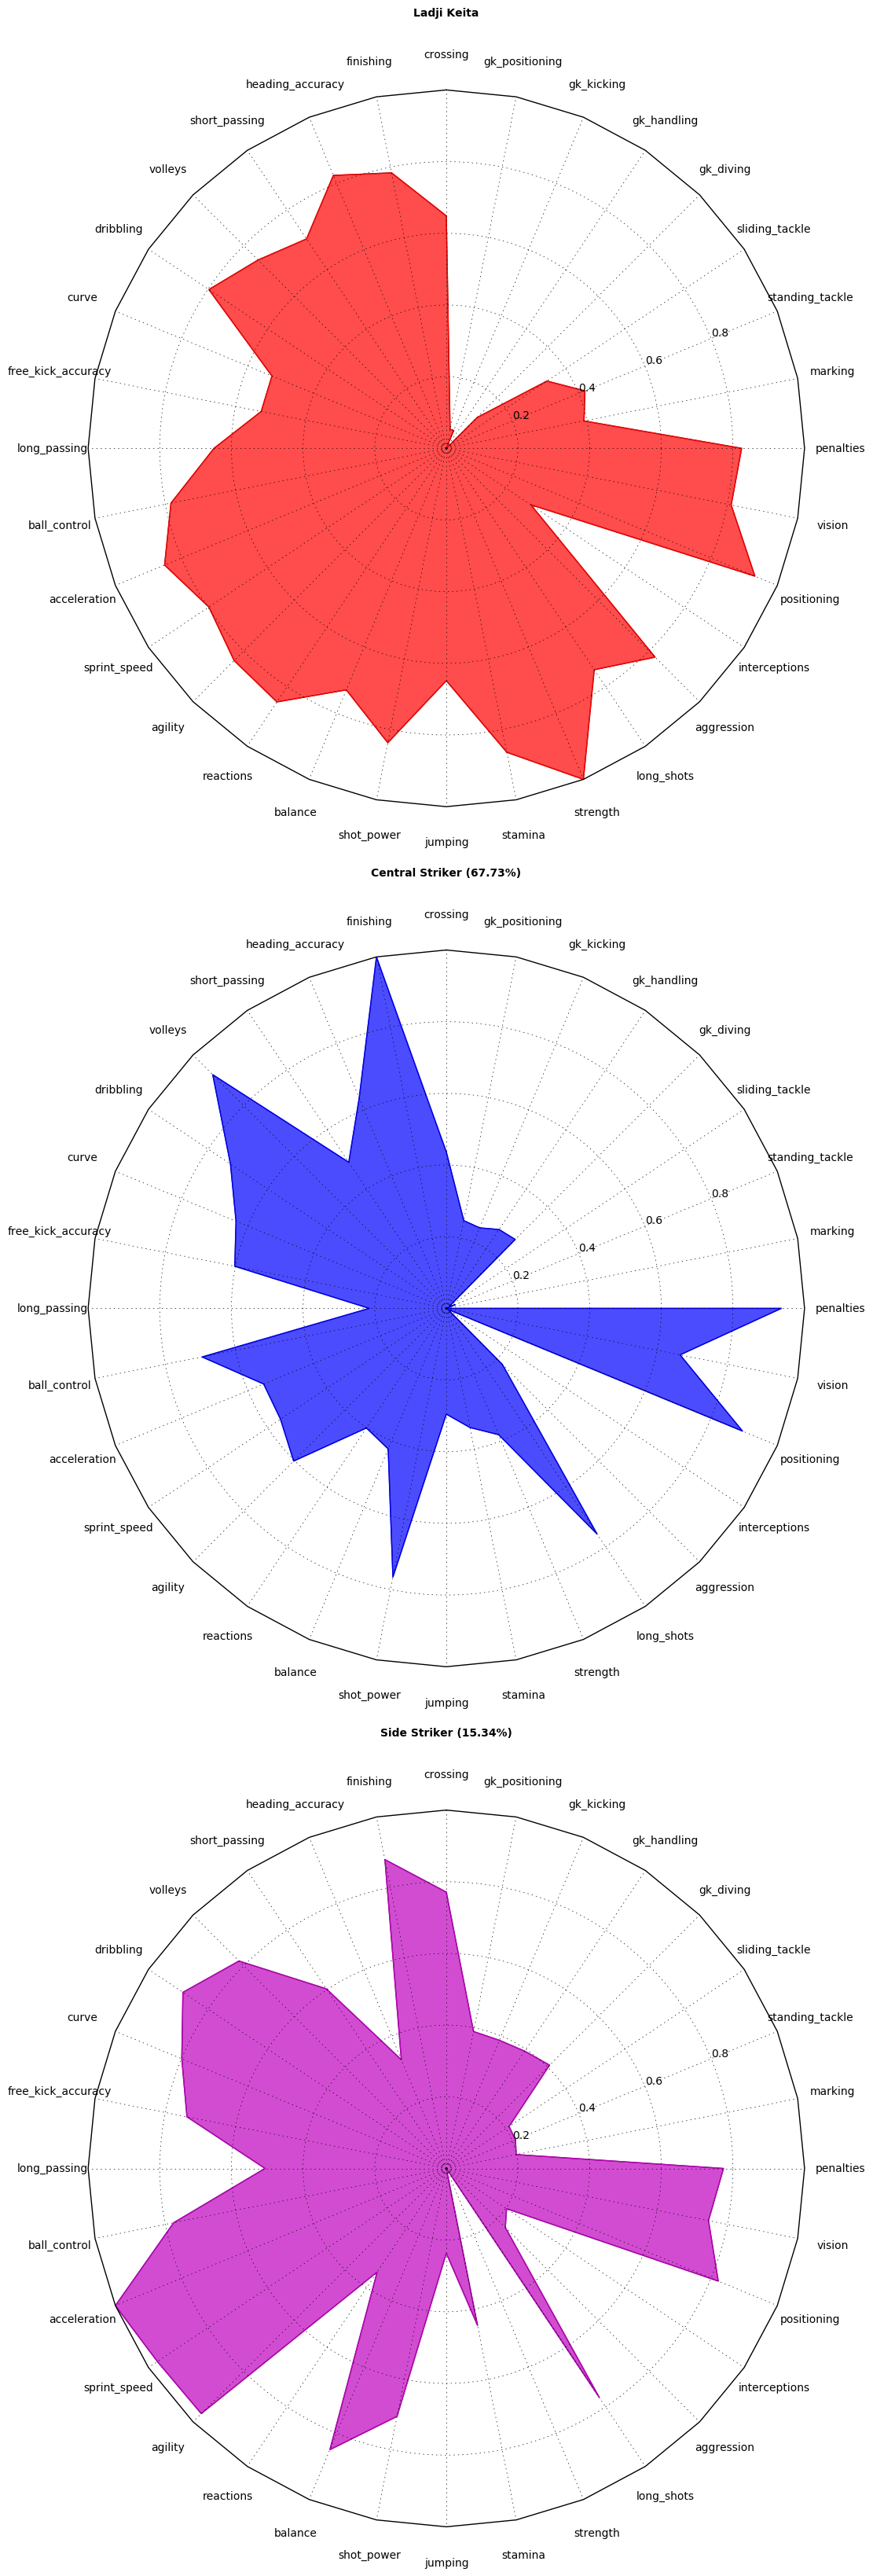

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
%run ./radar_helper.py

num_attributes = attributes_endingCol-attributes_startingCol #The total number of attributes for each player

radar_draw_obj = radar_factory(num_attributes, frame='polygon')
colors = ['b', 'm', 'g', 'c', 'y', 'r' , 'k']
attr_labels = player_attributes_table_data.columns[attributes_startingCol:attributes_endingCol]
fig = plt.figure(figsize=(40, 40))

num_subplots = len(predicted_compatible_positions) + 1

def draw_radar_subplot(data_tmp, ind_tmp, title_tmp, color_tmp, attr_tmp):
    ax = fig.add_subplot(num_subplots, 1, ind_tmp, projection='radar')
    ax.set_title(title_tmp, weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
    plt.rgrids([0.2,0.4,0.6,0.8])
    ax.plot(radar_draw_obj, data_tmp, color=color_tmp)
    ax.fill(radar_draw_obj, data_tmp, facecolor=color_tmp, alpha=0.7)
    ax.set_varlabels(attr_tmp)

draw_radar_subplot(current_player[0], 1, current_player_name, 'r', attr_labels)

for ind , val in enumerate(predicted_compatible_positions):
        draw_radar_subplot(estimated_coefficients[val[0]], ind+ 2, pos_labels[val[0]] + " (" + format(100*val[1],"3.2f") + "%)" , colors[ind], attr_labels)
        
plt.show()

Draw all positions learned attributes (this is plotted only for demonstration purposes)

All leagues


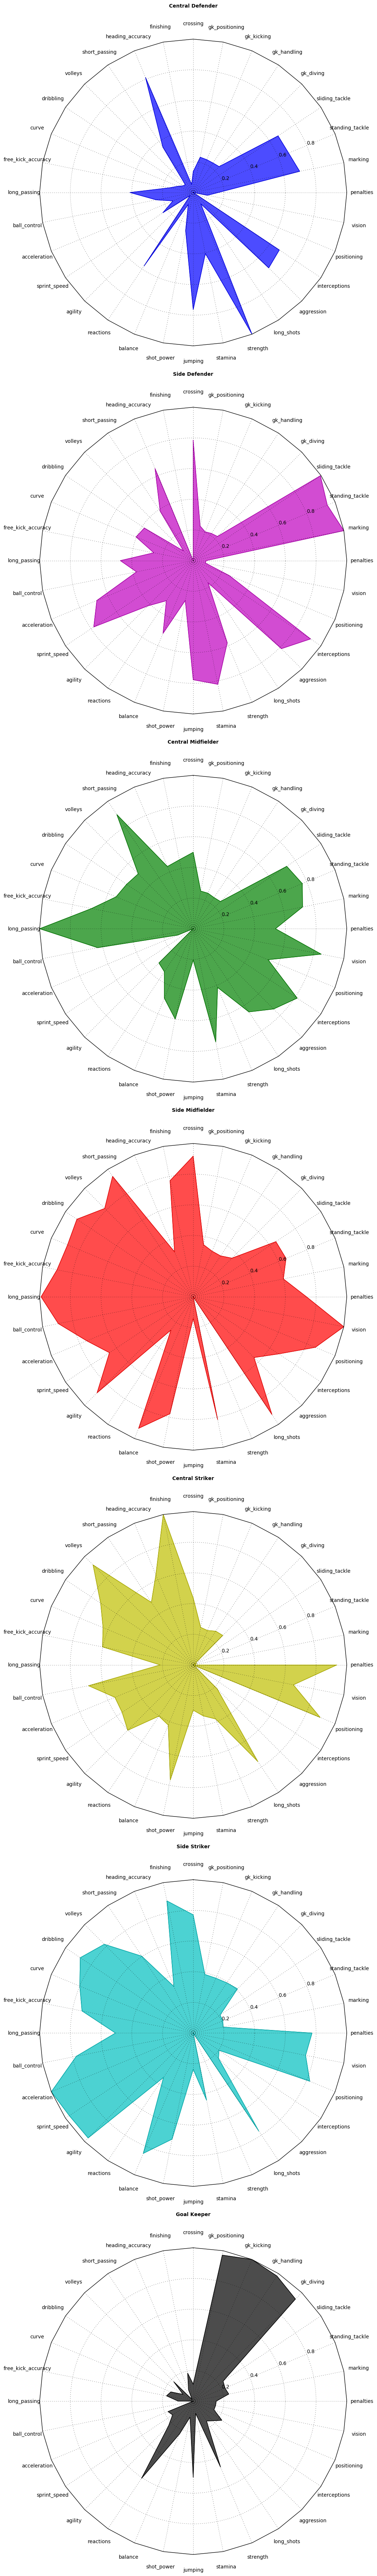

In [6]:
colors = ['b', 'm', 'g', 'r', 'y', 'c' , 'k']
attr_labels = player_attributes_table_data.columns[attributes_startingCol:attributes_endingCol]
fig = plt.figure(figsize=(90, 90))
print ('\033[1m' + leagues_names) #print League(s) Name(s) in bold

num_subplots = len(pos_labels)

def draw_radar_subplot(data_tmp, ind_tmp, title_tmp, color_tmp, attr_tmp):
    ax = fig.add_subplot(num_subplots, 1, ind_tmp, projection='radar')
    ax.set_title(title_tmp, weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')
    #ax.get_yaxis().set_visible(False)
    plt.rgrids([0.2,0.4,0.6,0.8])
    ax.plot(radar_draw_obj, data_tmp, color=color_tmp)
    ax.fill(radar_draw_obj, data_tmp, facecolor=color_tmp, alpha=0.7)
    ax.set_varlabels(attr_tmp)

for ind , val in enumerate(estimated_coefficients):
            draw_radar_subplot(val, ind+1, pos_labels[ind], colors[ind], attr_labels)
        
plt.show()

By Fatme Hachem